## Hybrid - Part 5: Final Dataset Feature Selection

**Environment Setup**

In [32]:
#Loading key libraries for later analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
pd.set_option('max_colwidth', 1000)
from sklearn.model_selection import cross_val_score, cross_validate,GridSearchCV,StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
import os
!pip install xgboost
!pip install spacy
import functions
from sklearn.linear_model import Lasso


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       

In [33]:
def evaluation_score(model,df):
    kfold = StratifiedKFold(n_splits=5,random_state=200,shuffle=True)
    scoring = ('accuracy','precision_macro','recall_macro','f1_macro')

    scores = cross_validate(model, df, y_train, cv=kfold, scoring= scoring, n_jobs = -1)
    sorted(scores.keys())
    accuracy = scores['test_accuracy'].mean()
    precision_macro = scores['test_precision_macro'].mean()
    recall_macro = scores['test_recall_macro'].mean()
    f1_macro = scores['test_f1_macro'].mean()
    print('Accuracy: {},Precision: {},Recall: {},F1 Score: {}'.format(round(accuracy,5),round(precision_macro,5),
                                                                                    round(recall_macro,5),round(f1_macro,5)))

In [34]:
#Read in bank transactions
Train = pd.read_csv(r'Train_hybrid_updated.csv',low_memory=False,encoding='latin1')
Test = pd.read_csv(r'Test_hybrid_updated.csv',low_memory=False,encoding='latin1')

In [35]:
#Prepare Final DataFrame
Train.index = Train['Unnamed: 0'].values
Train = functions.drop_column(Train,'Unnamed: 0')
Test.index = Test['Unnamed: 0'].values
Test = functions.drop_column(Test,'Unnamed: 0')
X_train = Train.iloc[:,:-1]
X_test = Test.iloc[:,:-1]
y_train = Train.iloc[:,-1]
y_test = Test.iloc[:,-1]

In [36]:
#Testing set with numerical features only
X_num_feat = X_train.iloc[:,-13:]

### 1. Feature Collinearity

In [15]:
#Check for multicollinearity
c = X_num_feat.corr().abs()
s = c.unstack()
#Sort by collinearity and show the top 30 most correlated features
corr = sorted(s.items(),key = lambda x: x[1],  reverse=True)
corr = [corr[x] for x in range(len(corr)) if corr[x][1]!=1]
corr[:30]

[(('week_of_month_2', 'week_of_month_3'), 0.3462754103956818),
 (('week_of_month_3', 'week_of_month_2'), 0.3462754103956818),
 (('amount_std', 'debit_binary'), 0.33272461276545445),
 (('debit_binary', 'amount_std'), 0.33272461276545445),
 (('week_of_month_3', 'week_of_month_4'), 0.317182914003467),
 (('week_of_month_4', 'week_of_month_3'), 0.317182914003467),
 (('week_of_month_2', 'week_of_month_4'), 0.2839340018962627),
 (('week_of_month_4', 'week_of_month_2'), 0.2839340018962627),
 (('amount_std', 'financing_binary'), 0.1924131534519537),
 (('financing_binary', 'amount_std'), 0.1924131534519537),
 (('financing_binary', 'token_length'), 0.18270536343625754),
 (('token_length', 'financing_binary'), 0.18270536343625754),
 (('amount_std', 'balance_std'), 0.16307940166965962),
 (('balance_std', 'amount_std'), 0.16307940166965962),
 (('hmrc_corp', 'hmrc_paye'), 0.10783736688322405),
 (('hmrc_paye', 'hmrc_corp'), 0.10783736688322405),
 (('debit_binary', 'financing_binary'), 0.10498984076399

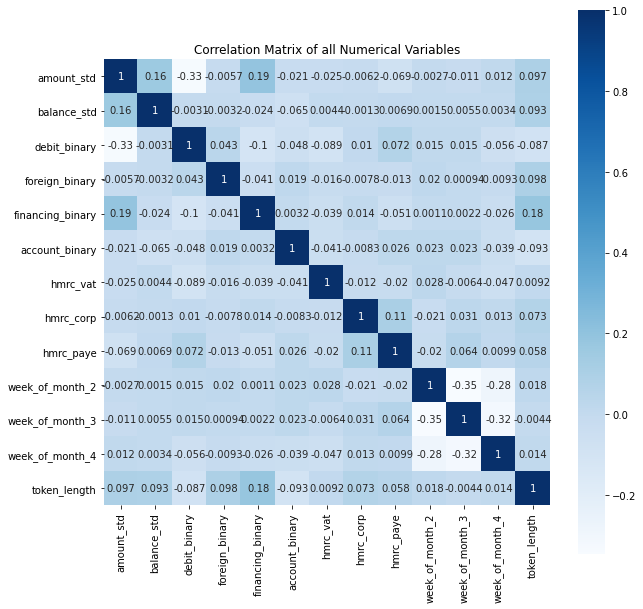

In [16]:
#plot the correlation map between all numerical features
def correlation_map(final_data):
    dfData =final_data.corr()
    plt.subplots(figsize=(10, 10)) 
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    plt.title('Correlation Matrix of all Numerical Variables')
    plt.savefig(r'corr matrix_hybrid.png',bbox_inches='tight')
    
correlation_map(X_num_feat)

In [17]:
#check the collinearity with VIF score, if the VIF score is higher than 10, it is more likely to be correlated
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Define the dependent and independent variables
vif1 = pd.DataFrame()
vif1["VIF Factor"] = [variance_inflation_factor(X_num_feat.values, i) for i in range(X_num_feat.shape[1])]
vif1["features"] = X_num_feat.columns
vif1.round(1)

,VIF Factor,features
0,1.2,amount_std
1,1.0,balance_std
2,2.5,debit_binary
3,1.0,foreign_binary
4,1.3,financing_binary
5,1.1,account_binary
6,1.0,hmrc_vat
7,1.0,hmrc_corp
8,1.0,hmrc_paye
9,1.6,week_of_month_2


### 2 Feature Importance： by Lasso regression

In [29]:
#create the lambda range
lambda_list = np.logspace(-6,6, num=100)
weights_lasso = []

#Fit training data into lasso (still numerical features only)
for lambda_value in lambda_list:    
    lassoreg = Lasso(alpha=lambda_value)
    lassoreg.fit(X_num_feat,y_train)
    weights_lasso.append(lassoreg.coef_) 

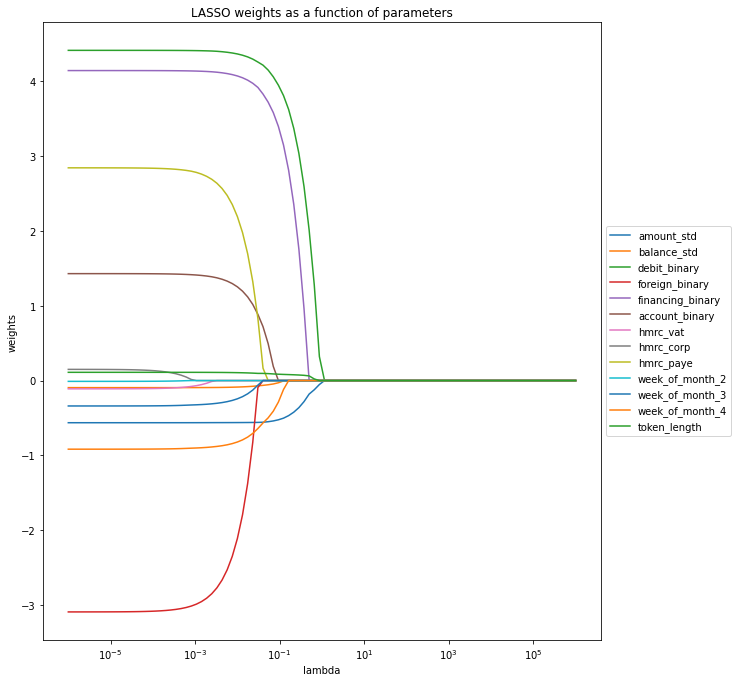

In [22]:
#plot the lasso graph to show importance virtually
X_colLabels=X_num_feat.columns
fig = plt.figure(figsize = (10,25))
ax = fig.add_subplot(212)
ax.plot(lambda_list, weights_lasso)
ax.set_xscale('log')
ax.legend(labels = X_colLabels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('LASSO weights as a function of parameters')
plt.savefig(r'lasso_hybrid.png',bbox_inches='tight')

## 3 Feature Selection

In [37]:
#Final model selected at model selection stage
et = ExtraTreesClassifier(max_depth= None,max_features='log2',min_samples_leaf= 1,min_samples_split= 5,n_estimators= 150)
kfold = StratifiedKFold(n_splits=5,random_state=200,shuffle=True)

#selection is conducted by defining features to be dropped
def feat_selection(drop_fea_dict):
    feat_result = dict()
    for key, value in drop_fea_dict.items():
        X = functions.drop_column(X_train,value)
        score = cross_val_score(et, X, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)
        feat_result[key] = score.mean()
        print('drop ({}) : {}'.format(key, score.mean()))

In [38]:
#defining features to be dropped
drop_feat = {
    'week_of_month_2' : ['week_of_month_2'],
    'hmrc_corp':['hmrc_corp'],
    'hmrc_corp+week_of_month_2': ['hmrc_corp', 'week_of_month_2'],
    'hmrc_corp+hmrc_vat+week_of_month_2' :['hmrc_corp', 'hmrc_vat','week_of_month_2'],
    'hmrc_corp+hmrc_vat+week_of_month_2+balance_std' :['hmrc_corp', 'hmrc_vat','balance_std','week_of_month_2'],
    'hmrc_corp+hmrc_vat+week_of_month_2+week_of_month_3' :['hmrc_corp', 'hmrc_vat','week_of_month_2','week_of_month_3'],
    'hmrc_corp+hmrc_vat+week_of_month_2+balance_std+week_of_month_3' :['hmrc_corp', 'hmrc_vat','balance_std','week_of_month_2','week_of_month_3'],
    'hmrc_corp+hmrc_vat+week_of_month_2+week_of_month_3+foreign_binary' :['hmrc_corp', 'hmrc_vat','week_of_month_2','week_of_month_3','foreign_binary'],
    'hmrc_corp+hmrc_vat+week_of_month_2+balance_std+week_of_month_3+token_length' :['hmrc_corp', 'hmrc_vat','balance_std','week_of_month_2','week_of_month_3','token_length'],
    'hmrc_corp+hmrc_vat+week_of_month_2+week_of_month_3+foreign_binary+hmrc_paye' :['hmrc_corp', 'hmrc_vat','week_of_month_2','week_of_month_3','foreign_binary','hmrc_paye'],
    'hmrc_corp+hmrc_vat+week_of_month_2+balance_std+week_of_month_3+token_length+amount_std' :['hmrc_corp', 'hmrc_vat','balance_std','week_of_month_2','week_of_month_3','token_length','amount_std'],
}

#create a benchmark model and its f1 score
bench = cross_val_score(et, X_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)
print('benchmark model : {}'.format(bench.mean()))

feat_selection(drop_feat)

benchmark model : 0.9268807176666771
drop (week_of_month_2) : 0.9240379065143133
drop (hmrc_corp) : 0.9222518910045985
drop (hmrc_corp+week_of_month_2) : 0.9248782929541596
drop (hmrc_corp+hmrc_vat+week_of_month_2) : 0.9237752159775111
drop (hmrc_corp+hmrc_vat+week_of_month_2+balance_std) : 0.9227158097680812
drop (hmrc_corp+hmrc_vat+week_of_month_2+week_of_month_3) : 0.9275555633831868
drop (hmrc_corp+hmrc_vat+week_of_month_2+balance_std+week_of_month_3) : 0.9231763012071271
drop (hmrc_corp+hmrc_vat+week_of_month_2+week_of_month_3+foreign_binary) : 0.9238268959055891
drop (hmrc_corp+hmrc_vat+week_of_month_2+balance_std+week_of_month_3+token_length) : 0.9275733108900027
drop (hmrc_corp+hmrc_vat+week_of_month_2+week_of_month_3+foreign_binary+hmrc_paye) : 0.9266820496857813
drop (hmrc_corp+hmrc_vat+week_of_month_2+balance_std+week_of_month_3+token_length+amount_std) : 0.9236322798480593
